NOTEBOOK : PIPELINE IDENTIFICATION FROM C3D

The point of this notebook is to take you through all the steps required to realize the identification of a human model composed of 36 dofs and 16 segments

First of all, we import the libraries needed for this.


In [1]:
import c3d

import numpy as np
import pinocchio as pin
import sys
from os.path import dirname, join, abspath

from parameters_settings import params_settings
from pinocchio.visualize import GepettoVisualizer
from tools.robot import load_model
from pinocchio.utils import *
from IK import *
from calibration import *

from tools.regressor import (
    get_standard_parameters,
    build_regressor_basic,
    get_index_eliminate,
    build_regressor_reduced,
)
from tools.qrdecomposition import get_baseParams
from tools.identification_functions_def import (
    low_pass_filter_data,
    relative_stdev,
    calculate_first_second_order_differentiation,
)

import pandas as pd
import matplotlib.pyplot as plt

<frozen importlib._bootstrap>:219: RuntimeWarning: to-Python converter for boost::shared_ptr<hpp::fcl::CollisionGeometry> already registered; second conversion method ignored.
/home/msabbah/.local/lib/python3.8/site-packages/ipopt/__init__.py:13: FutureWarning: The module has been renamed to 'cyipopt' from 'ipopt'. Please import using 'import cyipopt' and remove all uses of 'import ipopt' in your code as this will be deprecated in a future release.
  warnings.warn(msg, FutureWarning)


In [2]:
def Rquat(x, y, z, w):
    q = pin.Quaternion(x, y, z, w)
    q.normalize()
    return q.matrix()


def place(viz, name, M):
    viz.viewer.gui.applyConfiguration(name, pin.SE3ToXYZQUAT(M).tolist())
    viz.viewer.gui.refresh()


def make_markers_dict(PMarkers, markers_name, joints_width=None):
    values = []
    for ii in range(len(PMarkers)):
        values.append(PMarkers[ii])
    if joints_width is not None:
        markers_name.append("LKNEW")
        values.append(joints_width[0])
        markers_name.append("RKNEW")
        values.append(joints_width[1])
        markers_name.append("LANKW")
        values.append(joints_width[2])
        markers_name.append("RANKW")
        values.append(joints_width[3])
        markers_name.append("LELBW")
        values.append(joints_width[4])
        markers_name.append("RELBW")
        values.append(joints_width[5])
    return dict(zip(markers_name, values))


def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec


def compute_model_COM(model, data):
    COM_bb = []
    q0 = pin.neutral(model)
    pin.forwardKinematics(model, data, q0)
    pin.updateFramePlacements(model, data)
    id_lhip = model.getJointId("left_hip_Z")
    id_rhip = model.getJointId("right_hip_Z")
    id_abdo = model.getFrameId("middle_abdomen")
    id_lknee = model.getJointId("left_knee")
    id_rknee = model.getJointId("right_knee")
    id_lank = model.getJointId("left_ankle_X")
    id_rank = model.getJointId("right_ankle_X")
    id_thoracic = model.getJointId("middle_thoracic_X")
    id_neck = model.getJointId("middle_cervical_X")
    id_lsho = model.getJointId("left_shoulder_X")
    id_rsho = model.getJointId("right_shoulder_X")
    id_lelb = model.getJointId("left_elbow_Y")
    id_relb = model.getJointId("right_elbow_Y")
    id_lwrist = model.getJointId("left_wrist_Z")
    id_rwrist = model.getJointId("right_wrist_Z")
    COM_bb.append(0.05)  # pelvis_x
    COM_bb.append(
        (data.oMf[id_abdo].translation[2] - data.oMi[id_lhip].translation[2]) / 2
    )  # pelvis_y
    COM_bb.append(
        -(data.oMi[id_rhip].translation[1] - data.oMi[id_lhip].translation[1]) / 2
    )  # pelvis_z
    COM_bb.append(0.05)  # luppleg_x
    COM_bb.append(
        (data.oMi[id_lhip].translation[2] - data.oMi[id_lknee].translation[2]) / 2
    )  # luppleg_y
    COM_bb.append(0.05)  # luppleg_z (knee width)
    COM_bb.append(0.05)  # llowleg_x
    COM_bb.append(
        (data.oMi[id_lknee].translation[2] - data.oMi[id_lank].translation[2]) / 2
    )  # llowleg_y
    COM_bb.append(0.05)  # llowleg_z (knee width)
    COM_bb.append(0.10)  # lfoot_x
    COM_bb.append(0.02)  # lfoot_y
    COM_bb.append(0.05)  # lfoot_z
    COM_bb.append(0.05)  # abdomen_x
    COM_bb.append(
        (data.oMi[id_thoracic].translation[2] - data.oMi[id_abdo].translation[2]) / 2
    )  # abdomen_y
    COM_bb.append(
        -(data.oMi[id_rhip].translation[1] - data.oMi[id_lhip].translation[1]) / 2
    )  # abdomen_z
    COM_bb.append(0.10)  # thorax_x
    COM_bb.append(
        (data.oMi[id_neck].translation[2] - data.oMi[id_thoracic].translation[2]) / 2
    )  # thorax_y
    COM_bb.append(
        -(data.oMi[id_rsho].translation[1] - data.oMi[id_lsho].translation[1]) / 2
    )  # thorax_z
    COM_bb.append(0.03)  # lupparm_x
    COM_bb.append(
        (data.oMi[id_lsho].translation[2] - data.oMi[id_lelb].translation[2]) / 2
    )  # lupparm_y
    COM_bb.append(0.05)  # lupparm_z (elbow width)
    COM_bb.append(0.03)  # llowarm_x
    COM_bb.append(
        (data.oMi[id_lelb].translation[2] - data.oMi[id_lwrist].translation[2]) / 2
    )  # llowarm_y
    COM_bb.append(0.05)  # llowarm_z (elbow width)
    COM_bb.append(0.03)  # lhand_x
    COM_bb.append(0.1)  # lhand_y
    COM_bb.append(0.05)  # lhand_z
    COM_bb.append(0.1)  # head_x
    COM_bb.append(0.12)  # head_y
    COM_bb.append(0.07)  # head_z
    COM_bb.append(0.03)  # rupparm_x
    COM_bb.append(
        (data.oMi[id_rsho].translation[2] - data.oMi[id_relb].translation[2]) / 2
    )  # rupparm_y
    COM_bb.append(0.05)  # rupparm_z (elbow width)
    COM_bb.append(0.03)  # rlowarm_x
    COM_bb.append(
        (data.oMi[id_relb].translation[2] - data.oMi[id_rwrist].translation[2]) / 2
    )  # rlowarm_y
    COM_bb.append(0.05)  # rlowarm_z (elbow width)
    COM_bb.append(0.03)  # rhand_x
    COM_bb.append(0.1)  # rhand_y
    COM_bb.append(0.05)  # rhand_z
    COM_bb.append(0.05)  # ruppleg_x
    COM_bb.append(
        (data.oMi[id_rhip].translation[2] - data.oMi[id_rknee].translation[2]) / 2
    )  # ruppleg_y
    COM_bb.append(0.05)  # ruppleg_z (knee width)
    COM_bb.append(0.05)  # rlowleg_x
    COM_bb.append(
        (data.oMi[id_rknee].translation[2] - data.oMi[id_rank].translation[2]) / 2
    )  # rlowleg_y
    COM_bb.append(0.05)  # rlowleg_z (knee width)
    COM_bb.append(0.10)  # rfoot_x
    COM_bb.append(0.02)  # rfoot_y
    COM_bb.append(0.05)  # rfoot_z
    return np.array(COM_bb)


def display_bounding_boxes(viz, model, data, q, COM_min, COM_max, IDX):
    pin.forwardKinematics(model, data, q)
    pin.updateFramePlacements(model, data)
    for ii in range(len(IDX)):
        M = data.oMf[IDX[ii]]
        size_x = COM_max[3 * ii] - COM_min[3 * ii]
        size_y = COM_max[3 * ii + 1] - COM_min[3 * ii + 1]
        size_z = COM_max[3 * ii + 2] - COM_min[3 * ii + 2]
        viz.viewer.gui.addBox(
            "world/box" + str(ii), size_x, size_y, size_z, [0.5, 0, 0.5, 0.5]
        )
        place(viz, "world/box" + str(ii), M)

We first load the urdf representing the model and extract from it the pinocchio type needed to compute everything
In addition, we retrieve the indexes corresponding to actual real segments of the body (those with inertial properties) and the indexes corresponding to virtual segments (with no mass, only there to build the urdf)

In [3]:
robot = load_model("human_urdf", "human_corrige.urdf", params_settings)

model = robot.model
data = robot.data
nq = model.nq
nv = model.nv
nbodies = model.nbodies

id_inertias = []
id_virtual = []

for jj in range(1, len(model.inertias.tolist())):
    if model.inertias.tolist()[jj].mass != 0:
        id_inertias.append(jj - 1)
    else:
        id_virtual.append(jj - 1)

for k in range(len(model.inertias.tolist())):
    print(model.inertias.tolist()[k], model.inertias[k].toDynamicParameters())

print(id_inertias, id_virtual)

  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  m = 11.36
  c = -0.00018375 0.000551347    -0.02646
  I = 
   0.107721 -0.00137968  0.00546802
-0.00137968    0.096326 -0.00044804
 0.00546802 -0.00044804    0.107746 [ 1.13600000e+01 -2.08740000e-03  6.26330411e-03 -3.00585577e-01
  1.15677947e-01 -1.37852920e-03  1.04279881e-01  5.41279233e-03
 -2.82312934e-04  1.07749834e-01]
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  m = 0
  c = 0 0 0
  I = 
0 0 0
0 0 0
0 0 0 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
  m = 9.84
  c = -0.017507 -0.183183  0.014091
  I = 
   0.48303 -0.0227656 0.00170979
-0.0227656  0.0453373  0.0166081
0.00170979  0.0166081   0.494678 [ 9.84000000e+00 -1.72268880e-01 -1.80252072e+00  1.38655440e-01
  8.15174947e-01 -5.43223302e-02  5.03070051e-02  4.13723079e-03
  4.20074195e-02  8.27885064e-01]
  m = 3.84
  c =  -0.0205464   -0.175501 -0.00299635
  I = 
     0.17347   -0.0127209 -0.000517843
  -0.0127209   0.008

From a c3d file, we make the calibration of the motion capture system. The goal is to retrieve the position of the markers in each local frame of the body and to scale the lengths of some segments in the model. We average these positions over all the samples available in the c3d file.

IK STARTED (Beware, the calibration can take a while to be computed)

In [49]:
dataframe = []

with open("datasets/tPose02.c3d", "rb") as handle:
    reader = c3d.Reader(handle)
    for i, points in enumerate(reader.read_frames()):
        # print('Frame {}: {}'.format(i, points[1].round(2)))
        Position_markers = []
        for k in range(35):
            Position_markers.append([points[1][k][0], points[1][k][1], points[1][k][2]])

        Position_markers = np.array(Position_markers)
        Position_markers = Position_markers * 1e-3
        R = rotate("z", np.pi)

        # ALIGNING MEASURES AND MODEL
        for ii in range(len(Position_markers)):
            Position_markers[ii] = R @ Position_markers[ii]

        names = [
            "LFHD",
            "RFHD",
            "LBHD",
            "RBHD",
            "C7",
            "T10",
            "CLAV",
            "STRN",
            "RBAK",
            "LSHO",
            "LELB",
            "LWRA",
            "LWRB",
            "LFIN",
            "RSHO",
            "RELB",
            "RWRA",
            "RWRB",
            "RFIN",
            "LASI",
            "RASI",
            "LPSI",
            "RPSI",
            "LTHI",
            "LKNE",
            "LTIB",
            "LANK",
            "LHEE",
            "LTOE",
            "RTHI",
            "RKNE",
            "RTIB",
            "RANK",
            "RHEE",
            "RTOE",
        ]
        joints_width = [0.10, 0.10, 0.07, 0.07, 0.05, 0.05]  # KNEE ANKLE ELBOW

        dictio = make_markers_dict(Position_markers, names, joints_width)

        joints_center = compute_joint_centers(dictio)

        # Change body segments sizes (example, the left lowerleg)
        model = scale_human_model(model, joints_center)

        q_tPose = np.zeros((43,))
        q_tPose[20] = -np.pi / 2
        q_tPose[31] = -np.pi / 2

        q0 = calibrate_human_model(robot, joints_center, q_tPose)

        markers_local = get_local_markers(model, data, q0, dictio)

        markers_for_df = markers_local_for_df(markers_local)

        dataframe.append(markers_for_df)

/home/msabbah/.local/lib/python3.8/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



Data analysis over all sample here

        LFHDx     LFHDy     LFHDz     RFHDx     RFHDy     RFHDz     LBHDx  \
0    0.137903  0.186803 -0.053546  0.114277  0.194470  0.069258  0.005995   
1    0.139347  0.189042 -0.048272  0.112273  0.196033  0.073748  0.008560   
2    0.140448  0.190079 -0.046765  0.111627  0.198057  0.074850  0.010466   
3    0.142345  0.185945 -0.050210  0.119370  0.192201  0.072688  0.009720   
4    0.141491  0.185804 -0.049903  0.118123  0.192860  0.073155  0.009010   
..        ...       ...       ...       ...       ...       ...       ...   
441  0.141697  0.175802 -0.053490  0.132964  0.178293  0.070885  0.001942   
443  0.144688  0.174010 -0.063516  0.138794  0.179643  0.060598  0.004384   
444  0.146643  0.175601 -0.059865  0.139103  0.180997  0.063970  0.006675   
445  0.147683  0.173912 -0.060906  0.141830  0.178064  0.062636  0.007253   
446  0.144909  0.174115 -0.063109  0.139390  0.179257  0.061125  0.004363   

        LBHDy     LBHDz     RBHDx  ...     RTIBz     RANKx     RANKy  \
0  

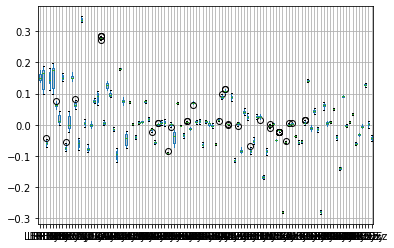

In [50]:
df = pd.DataFrame(dataframe)

# On supprime les valeurs aberrantes
for ii in [
    "LFHDx",
    "LFHDy",
    "LFHDz",
    "RFHDx",
    "RFHDy",
    "RFHDz",
    "LBHDx",
    "LBHDy",
    "LBHDz",
    "RBHDx",
    "RBHDy",
    "RBHDz",
    "C7x",
    "C7y",
    "C7z",
    "T10x",
    "T10y",
    "T10z",
    "CLAVx",
    "CLAVy",
    "CLAVz",
    "STRNx",
    "STRNy",
    "STRNz",
    "RBAKx",
    "RBAKy",
    "RBAKz",
    "LSHOx",
    "LSHOy",
    "LSHOz",
    "LELBx",
    "LELBy",
    "LELBz",
    "LWRAx",
    "LWRAy",
    "LWRAz",
    "LWRBx",
    "LWRBy",
    "LWRBz",
    "LFINx",
    "LFINy",
    "LFINz",
    "RSHOx",
    "RSHOy",
    "RSHOz",
    "RELBx",
    "RELBy",
    "RELBz",
    "RWRAx",
    "RWRAy",
    "RWRAz",
    "RWRBx",
    "RWRBy",
    "RWRBz",
    "RFINx",
    "RFINy",
    "RFINz",
    "LASIx",
    "LASIy",
    "LASIz",
    "RASIx",
    "RASIy",
    "RASIz",
    "LPSIx",
    "LPSIy",
    "LPSIz",
    "RPSIx",
    "RPSIy",
    "RPSIz",
    "LTHIx",
    "LTHIy",
    "LTHIz",
    "LKNEx",
    "LKNEy",
    "LKNEz",
    "LTIBx",
    "LTIBy",
    "LTIBz",
    "LANKx",
    "LANKy",
    "LANKz",
    "LHEEx",
    "LHEEy",
    "LHEEz",
    "LTOEx",
    "LTOEy",
    "LTOEz",
    "RTHIx",
    "RTHIy",
    "RTHIz",
    "RKNEx",
    "RKNEy",
    "RKNEz",
    "RTIBx",
    "RTIBy",
    "RTIBz",
    "RANKx",
    "RANKy",
    "RANKz",
    "RHEEx",
    "RHEEy",
    "RHEEz",
    "RTOEx",
    "RTOEy",
    "RTOEz",
]:

    # On calcule Q1

    q1 = df[ii].quantile(q=0.25)

    # On calcule Q3

    q3 = df[ii].quantile(q=0.75)

    # On calcule l'écart interquartile (IQR)

    IQR = q3 - q1

    # On calcule la borne inférieure à l'aide du Q1 et de l'écart interquartile

    borne_inf = q1 - 1.5 * IQR

    # On calcule la borne supérieure à l'aide du Q3 et de l'écart interquartile

    borne_sup = q3 + 1.5 * IQR

    # On garde les valeurs à l'intérieur de la borne inférieure et supérieure

    df = df[df[ii] < borne_sup]
    df = df[df[ii] > borne_inf]

mean = df.mean()
std = df.std()
print(df, mean, std)

boxplot = df.boxplot()
boxplot.plot()
plt.show()

We update the model by adding frames corresponding to each markers of the plug in gait template. It will be used for the IK

In [51]:
markers_local = mean_local_markers(mean)
print(markers_local)
data, i_markers = add_markers_frames(model, data, markers_local)

{'LFHD': array([ 0.1544976,  0.1532365, -0.0595262]), 'RFHD': array([0.14784169, 0.15838404, 0.06445178]), 'LBHD': array([ 0.01702253,  0.15244934, -0.07379293]), 'RBHD': array([0.00569034, 0.15262426, 0.06483365]), 'C7': array([-0.06025537,  0.3372045 ,  0.0046502 ]), 'T10': array([-0.07768623, -0.00055328,  0.07647687]), 'CLAV': array([0.08891294, 0.27939016, 0.00663781]), 'STRN': array([ 0.12554402,  0.09775679, -0.01443601]), 'RBAK': array([-0.0968849 ,  0.17951828,  0.07580854]), 'LSHO': array([-0.04539899,  0.07349426,  0.0017772 ]), 'LELB': array([-0.03984741,  0.00660865,  0.00927567]), 'LWRA': array([ 0.07518584,  0.01862026, -0.01515084]), 'LWRB': array([-0.05674546,  0.00162353,  0.00681394]), 'LFIN': array([ 0.00730681, -0.0903903 ,  0.00059352]), 'RSHO': array([-0.04014374,  0.06895678, -0.00301625]), 'RELB': array([-0.03257913,  0.00797845, -0.01317836]), 'RWRA': array([0.07004242, 0.00929296, 0.01074718]), 'RWRB': array([-0.06394493,  0.01035436,  0.00355737]), 'RFIN': a

In [52]:
# #DISPLAYS THE MARKERS
# viz = GepettoVisualizer(robot.model, robot.collision_model, robot.visual_model)

# try:
#     viz.initViewer()
# except ImportError as err:
#     print("Error while initializing the viewer. It seems you should install gepetto-viewer")
#     print(err)
#     sys.exit(0)

# try:
#     viz.loadViewerModel("pinocchio")
# except AttributeError as err:
#     print("Error while loading the viewer model. It seems you should start gepetto-viewer")
#     print(err)
#     sys.exit(0)

# q0=pin.neutral(model)
# # q0[7:]=np.array([0.35860343 ,-0.05140581,  0.01763003 , 0.09633949 , 0.12277045,0.,3.04991144,  3.10134096 , 2.22962475 , 3.10404487, -0.07789955,0, -2.45619911 ,-2.95241458 , 2.52722128 , 0.31927801 , 0.13022327,0.08799577  ,0.    ,     -0.25745391 , 0.    ,      0.   ,      -0.25963584, -2.43495363 ,-2.90834898 , 2.34627809 , 0.35541631 ,-0.16130867  ,0.07907891  ,0.        ,  0.33037161 ,-0.01237962 ,-0.2673288  , 0.07517449  ,0.1410749,0.])
# print(q0)
# pin.forwardKinematics(model,data,q0)
# pin.updateFramePlacements(model,data)

# viz.display(q0)

# for ii in range(len(i_markers)):
#         Mposition_goal_temp = data.oMf[i_markers[ii]]
#         viz.viewer.gui.addXYZaxis('world/markersframe'+str(ii), [0, 0., 1., 1.], 0.0115, 0.15)
#         place(viz,'world/markersframe'+str(ii), Mposition_goal_temp)

From another c3d representing an actual experiment (here the person was doing squat), we realize the Inverse Kinematics (IK) of the whole model. As an output, we get the angular positions for each joint of the body through time.

In [53]:
qlist = []

with open("datasets/Trial01.c3d", "rb") as handle:
    reader = c3d.Reader(handle)
    for ii, points in enumerate(reader.read_frames()):

        Position_markers = []
        for k in range(35):
            Position_markers.append([points[1][k][0], points[1][k][1], points[1][k][2]])

        Position_markers = np.array(Position_markers)
        Position_markers = Position_markers * 1e-3
        R = rotate("z", np.pi)

        # ALIGNING MEASURES AND MODEL
        for i in range(len(Position_markers)):
            Position_markers[i] = R @ Position_markers[i]

        names = [
            "LFHD",
            "RFHD",
            "LBHD",
            "RBHD",
            "C7",
            "T10",
            "CLAV",
            "STRN",
            "RBAK",
            "LSHO",
            "LELB",
            "LWRA",
            "LWRB",
            "LFIN",
            "RSHO",
            "RELB",
            "RWRA",
            "RWRB",
            "RFIN",
            "LASI",
            "RASI",
            "LPSI",
            "RPSI",
            "LTHI",
            "LKNE",
            "LTIB",
            "LANK",
            "LHEE",
            "LTOE",
            "RTHI",
            "RKNE",
            "RTIB",
            "RANK",
            "RHEE",
            "RTOE",
        ]
        DMarkers = make_markers_dict(Position_markers, names)

        if ii == 0:
            q_init = init_human_model(model, data, DMarkers, i_markers, q0)
            pin.forwardKinematics(model, data, q_init)
            pin.updateFramePlacements(model, data)
            qlist.append(q_init)

            Mposition_markers = np.empty(shape=[0, 3])
            for k in range(len(i_markers)):
                Mposition_markers = np.concatenate(
                    (
                        Mposition_markers,
                        np.reshape(data.oMf[i_markers[k]].translation, (1, 3)),
                    ),
                    axis=0,
                )

        q0 = IK_markers_human_quadprog(model, data, DMarkers, i_markers, q_init)
        qlist.append(q0)
        q_init = q0

print(qlist)

/home/msabbah/.local/lib/python3.8/site-packages/c3d/c3d.py:1219: UserWarning: No analog data found in file.
  warnings.warn('No analog data found in file.')


[array([-1.04392071e+00, -2.47464535e-01,  8.42744938e-01, -2.44518424e-02,
        4.76507972e-02, -1.00201996e-02,  9.98514450e-01, -4.77439142e-02,
       -8.72367670e-02, -1.57162420e-01,  2.55028300e-02, -6.03971334e-03,
        2.59739697e-01,  2.75717441e-01,  3.79508019e-02, -2.83804403e-01,
        2.16995729e-02, -5.06805465e-02, -2.31568884e-02,  3.92699000e-01,
       -3.66865687e-01, -8.67656293e-02,  4.03882253e-01,  3.54961823e-01,
        2.12864633e-02, -2.10539935e-06,  3.86193806e-01, -2.27101925e-06,
       -2.41140474e-06, -1.32956885e-01,  3.92699000e-01, -4.74936177e-01,
       -2.14825639e-01,  4.33513952e-01,  1.86656421e-01,  1.70945189e-02,
       -2.10538736e-06, -4.35049484e-02,  1.39840732e-02, -1.79077910e-01,
        8.26464299e-03, -2.54115345e-02,  2.59739697e-01]), array([-1.04392071e+00, -2.47464535e-01,  8.42744938e-01, -2.44518424e-02,
        4.76507972e-02, -1.00201996e-02,  9.98514450e-01, -4.77439142e-02,
       -8.72367670e-02, -1.57162420e-01

IK FINISHED

IDENTIFICATION PROCESS

We jump now into the identification process. The first step is to get the base parameters of the structure, ie., the linear combinations between inertial parameters that have influence on the cinematic structure of the body. For that, we generate random trajectories and build the basic regressor.

In [4]:
### BASE PARAMETERS ###

# generate a list containing the full set of standard parameters
# params_standard = robot.get_standard_parameters()
params_standard = get_standard_parameters(robot, params_settings)

# 1. First we build the structural base identification model, i.e. the one that can
# be observed, using random samples


q_filt = np.random.uniform(
    low=-6, high=6, size=(10 * params_settings["nb_samples"], nq)
)

dq_filt = np.random.uniform(
    low=-6, high=6, size=(10 * params_settings["nb_samples"], nv)
)

ddq_filt = np.random.uniform(
    low=-6, high=6, size=(10 * params_settings["nb_samples"], nv)
)

W = build_regressor_basic(robot, q_filt, dq_filt, ddq_filt, params_settings)

# remove zero cols and build a zero columns free regressor matrix
idx_e, params_r = get_index_eliminate(W, params_standard, 1e-6)
W_e = build_regressor_reduced(W, idx_e)

# Calulate the base regressor matrix, the base regroupings equations params_base and
# get the idx_base, ie. the index of base parameters in the initial regressor matrix
_, params_base, idx_base = get_baseParams(W_e, params_r, params_standard)

print("The structural base parameters are: ")
for ii in range(len(params_base)):
    print(params_base[ii])

The structural base parameters are: 
Ixx0 + 1.0*Iyy1 - 0.15995*mz1 + 0.012006*m1 + 1.0*Izz2 + 0.012006*m2 + 1.0*Izz3 + 0.012006*m3 + 0.194335*m4 + 0.194335*m5 + 0.194335*m6 + 1.0*Iyy7 + 1.0*Izz8 + 0.022283*m9 + 0.022283*m10 + 0.022283*m11 + 0.022283*m12 + 0.022283*m13 + 0.022283*m14 + 0.022283*m15 + 0.022283*m16 + 0.022283*m17 + 0.022283*m18 + 0.022283*m19 + 0.022283*m20 + 0.022283*m21 + 0.022283*m22 + 0.022283*m23 + 0.022283*m24 + 0.022283*m25 + 0.022283*m26 + 0.022283*m27 + 0.022283*m28 + 0.022283*m29 + 0.022283*m30 + 1.0*Iyy31 + 0.15995*mz31 + 0.012006*m31 + 1.0*Izz32 + 0.012006*m32 + 1.0*Izz33 + 0.012006*m33 + 0.194335*m34 + 0.194335*m35 + 0.194335*m36
Ixy0 + 0.053375*mz1 - 0.004269*m1 - 0.004269*m2 - 0.004269*m3 - 0.004269*m4 - 0.004269*m5 - 0.004269*m6 + 0.053375*mz31 + 0.004269*m31 + 0.004269*m32 + 0.004269*m33 + 0.004269*m34 + 0.004269*m35 + 0.004269*m36
Ixz0 + 0.003998*m1 + 0.003998*m2 + 0.003998*m3 + 0.003998*m4 + 0.003998*m5 + 0.003998*m6 + 0.003998*m31 + 0.003998*m32 + 0.00

Below some testings have been made, please don't mind them !

In [5]:
# #TEST OF PIN.DIFFERENCE
# f = 10
# delta_t=0.01
# samples=100
# w = 2.*np.pi*f
# t = np.linspace(0, int(samples*delta_t), samples)
# y= np.array(np.sin(w*t))
# y_point=np.array(w*np.cos(w*t))


# q=np.zeros((samples,43))
# dq_calc=np.zeros((samples,42))
# dq_pin=np.zeros((samples,42))


# for i in range(len(y)):
#     for j in range(43):
#         q[i][j]=y[i]

# for i in range(len(q)):
#     q[i]=pin.normalize(model,q[i])


# for i in range(samples-1):
#     dq=pin.difference(model,q[i,:],q[i+1,:])/delta_t
#     dq_pin[i,:]=dq


# for i in range(len(y_point)):
#     for j in range(42):
#         dq_calc[i][j]=y_point[i]

# np.set_printoptions(threshold=np.inf)

# print(dq_pin)
# print(dq_calc)


# plt.plot(dq_calc[:,-1],'--')
# plt.plot(dq_pin[:,-1])

In [6]:
# def calculate_first_second_order_differentiation(model,data,param):
#     print(data.shape)
#     # calculate vel and acc by central difference
#     # dt = param['ts']
#     dt=0.01
#     if param['is_joint_torques']:
#         ddata = np.zeros([data.shape[0], data.shape[1]])
#         dddata = np.zeros([data.shape[0], data.shape[1]])

#     if param['is_external_wrench']:
#         ddata = np.zeros([data.shape[0], data.shape[1]-1])
#         dddata = np.zeros([data.shape[0], data.shape[1]-1])

#     for ii in range(data.shape[0]-1):
#         ddata[ii,:] = pin.difference(model,data[ii,:],data[ii+1,:])/dt

#     for ii in range(data.shape[0]):
#         dddata[ii,:] = np.gradient(ddata[ii,:], edge_order=1) / dt

#     return ddata, dddata

Ideally, we should filter and differentiate the angular positions that we get from the previous IK. However, it has to be perfected so we only will simulate sinus trajectories.

In [72]:
# Mise en forme de qlist
q = np.array(qlist)

for ii in range(nq):
    if ii == 0:
        q_filt = low_pass_filter_data(q[:, ii], params_settings)
    else:
        q_filt = np.column_stack(
            (q_filt, low_pass_filter_data(q[:, ii], params_settings))
        )

# print(q_filt)

dq_filt, ddq_filt = calculate_first_second_order_differentiation(
    model, q_filt, params_settings
)

np.set_printoptions(threshold=np.inf)
print(dq_filt)
print(ddq_filt)

(2313, 43)
[[ 1.33226763e-12  4.44089210e-14 -1.77635684e-13 -5.20417043e-16
   2.30371278e-13 -7.65013053e-14 -3.33066907e-14  1.11022302e-14
  -4.44089210e-14  1.11022302e-14  1.24900090e-14  0.00000000e+00
  -3.10862447e-13  0.00000000e+00  1.77635684e-13 -5.55111512e-15
  -2.22044605e-14 -2.77555756e-15  4.44089210e-14 -4.88498131e-13
   2.44249065e-13  8.88178420e-13 -8.88178420e-14 -3.33066907e-14
  -3.38813179e-19 -8.88178420e-14 -1.35525272e-18  3.72694497e-18
   6.66133815e-14 -4.88498131e-13  6.21724894e-13 -1.77635684e-13
   3.10862447e-13  2.22044605e-13 -2.77555756e-15  0.00000000e+00
  -3.33066907e-14  5.55111512e-15  3.10862447e-13  1.38777878e-14
  -5.55111512e-15  0.00000000e+00]
 [ 1.33226763e-12  8.88178420e-14 -4.88498131e-13 -9.32413868e-15
   3.35842465e-13 -5.82867088e-14 -2.22044605e-14  0.00000000e+00
  -4.44089210e-14  2.77555756e-15  1.11022302e-14  1.33226763e-13
   0.00000000e+00  0.00000000e+00 -1.33226763e-13  0.00000000e+00
  -2.22044605e-14 -8.32667268e

SIMULATIONS WITH SIN

[[ 1.00000000e-04  2.00000000e-04  3.00000000e-04  1.99924983e-04
   2.50059981e-04  2.99949980e-04  9.99999904e-01  7.00000000e-04
   8.00000000e-04  9.00000000e-04  1.00000000e-03  1.10000000e-03
   1.20000000e-03  1.30000000e-03  1.40000000e-03  1.50000000e-03
   1.60000000e-03  1.70000000e-03  1.80000000e-03  1.90000000e-03
   2.00000000e-03  2.10000000e-03  2.20000000e-03  2.30000000e-03
   2.40000000e-03  2.50000000e-03  2.60000000e-03  2.70000000e-03
   2.80000000e-03  2.90000000e-03  3.00000000e-03  3.10000000e-03
   3.20000000e-03  3.30000000e-03  3.40000000e-03  3.50000000e-03
   3.60000000e-03  3.70000000e-03  3.80000000e-03  3.90000000e-03
   4.00000000e-03  4.10000000e-03  4.20000000e-03]
 [ 4.33881746e-03  4.43962622e-03  4.54043499e-03  2.31486522e-03
   2.37662991e-03  2.41591273e-03  9.99991578e-01  4.94367007e-03
   5.04447884e-03  5.14528761e-03  5.24609637e-03  5.34690514e-03
   5.44771391e-03  5.54852268e-03  5.64933145e-03  5.75014022e-03
   5.85094899e-03  5.9517

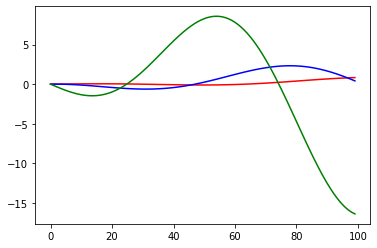

In [7]:
from scipy.spatial.transform import Rotation

## SIMU TRAJ SINUS
delta_t = 0.01
f = 1

samples = 100
w = 2.0 * np.pi * f

t = np.linspace(0, int(samples * delta_t), samples)

a = 0.0001
b = 0.0005

q_filt = np.zeros((samples, 43))
dq_filt = np.zeros((samples, 42))
ddq_filt = np.zeros((samples, 42))

for ii in range(len(t)):
    for jj in range(3):
        y = a * np.cos(w * t[ii]) + b * t[ii]
        q_filt[ii][jj] = y
        a += 0.0001
        b += 0.0001
    euler = []
    for jj in range(3, 6):
        euler.append(a * np.cos(w * t[ii]) + b * t[ii])
        a += 0.0001
        b += 0.0001
    rot = Rotation.from_euler("xyz", euler, degrees=False)
    # Convert to quaternions and print
    rot_quat = rot.as_quat()
    q_filt[ii, 3:7] = rot_quat
    for jj in range(7, 43):
        y = a * np.cos(w * t[ii]) + b * t[ii]
        q_filt[ii][jj] = y
        a += 0.0001
        b += 0.0001

a = 0.0001
b = 0.0005

for ii in range(len(t)):
    for jj in range(42):
        y_point = -a * w * np.array(np.sin(w * t[ii])) + b
        y_2_points = -a * w * w * np.array(np.cos(w * t[ii]))
        dq_filt[ii][jj] = y_point
        ddq_filt[ii][jj] = y_2_points
        a += 0.0001
        b += 0.0001

np.set_printoptions(threshold=np.inf)
print(q_filt, dq_filt, ddq_filt)

plt.plot(q_filt[:, 0], "r")
plt.plot(dq_filt[:, 0], "b")
plt.plot(ddq_filt[:, 0], "g")

Here, we retrieve the values of the base parameters thanks to a least-square algorithm

In [8]:
nb_samples = len(q_filt)

W = build_regressor_basic(robot, q_filt, dq_filt, ddq_filt, params_settings)
# select only the columns of the regressor corresponding to the structural base
# parameters
W_base = W[:, idx_base]
print("When using all trajectories the cond num is", int(np.linalg.cond(W_base)))

params_standard_u = get_standard_parameters(robot, params_settings)

# simulation of the measured joint torques
tau_meas = np.empty(nb_samples * 6)

for ii in range(nb_samples):
    tau_temp = pin.rnea(model, data, q_filt[ii, :], dq_filt[ii, :], ddq_filt[ii, :])
    for j in range(6):
        tau_meas[j * nb_samples + ii] = tau_temp[j]


# Least-square identification process
phi_base = np.matmul(np.linalg.pinv(W_base), tau_meas)
print(phi_base)

When using all trajectories the cond num is 926445227954290560
[ 5.46875000e-01  1.32812500e-01  7.31933594e-01  1.14746094e-02
  6.02539062e-01  5.91796875e-01  1.69856644e+00 -2.00242996e-01
 -2.68714523e+00  8.27430000e+01  1.10839844e-01 -1.03515625e-01
  1.97875977e-01  1.62109375e-01  1.70898438e-02  3.81469727e-05
 -2.86102295e-05  1.01806641e-01  1.85546875e-01  1.24053955e-01
 -5.88378906e-02 -8.93554688e-02 -3.85200500e+00 -4.95910645e-05
  9.68017578e-02  6.12792969e-02 -2.08007812e-01 -4.23828125e-01
 -2.41333008e-01 -1.72277451e-01  1.27145767e-01  3.36120605e-01
  1.60827637e-02  8.30078125e-03 -2.44140625e-03  6.39038086e-01
 -7.89031982e-02 -1.08480072e+00  1.72241211e-01  8.59375000e-02
 -1.05468750e-01 -8.98437500e-02  6.32263184e-01  6.63676262e-02
 -2.13623047e-04  2.89184570e-01 -6.09130859e-02 -5.94635010e-02
  4.66308594e-02 -3.05175781e-02 -2.62529850e-02 -4.43744659e-03
  1.94824219e-01 -1.02661133e-01  1.06994629e-01  4.84008789e-02
  6.79931641e-02  6.0852050

Then with a QP algorithm, we retrieve each standard parameters, that is to say we "deconstruct" the linear combinations that we were talking about above.

In [9]:
##QP OPTIMISATION

alpha = 0.8
phi_ref = []
nreal = len(id_inertias)
nvirtual = len(id_virtual)
nbodies = nreal + nvirtual


params_name = (
    "Ixx",
    "Ixy",
    "Ixz",
    "Iyy",
    "Iyz",
    "Izz",
    "mx",
    "my",
    "mz",
    "m",
)


for k in range(nbodies):
    for j in params_name:
        phi_ref_temp = params_standard_u[j + str(k)]
        phi_ref.append(phi_ref_temp)

phi_ref = np.array(phi_ref)


P = np.matmul(W.T, W) + alpha * np.eye(10 * (nbodies))
r = -(np.matmul(tau_meas.T, W) + alpha * phi_ref.T)

##Setting constraints
epsilon = 0.1
COM_bb = compute_model_COM(model, data)
COM_max = COM_bb
COM_min = -COM_bb


v = sample_spherical(2000)  # vectors over the unit sphere

G = np.zeros(((7 + len(v[0])) * (nreal), 10 * (nbodies)))
h = np.zeros((((7 + len(v[0])) * (nreal), 1)))
A = np.zeros((10 * (nvirtual), 10 * (nbodies)))
b = np.zeros((10 * nvirtual, 1))


for ii in range(len(id_inertias)):
    for k in range(
        len(v[0])
    ):  # inertia matrix def pos for enough (ie. 2000 here) vectors on unit sphere
        G[ii * (len(v[0]) + 7) + k][id_inertias[ii] * 10 + 0] = -v[0][k] ** 2
        G[ii * (len(v[0]) + 7) + k][id_inertias[ii] * 10 + 1] = -2 * v[0][k] * v[1][k]
        G[ii * (len(v[0]) + 7) + k][id_inertias[ii] * 10 + 2] = -2 * v[0][k] * v[2][k]
        G[ii * (len(v[0]) + 7) + k][id_inertias[ii] * 10 + 3] = -v[1][k] ** 2
        G[ii * (len(v[0]) + 7) + k][id_inertias[ii] * 10 + 4] = -2 * v[1][k] * v[2][k]
        G[ii * (len(v[0]) + 7) + k][id_inertias[ii] * 10 + 5] = -v[2][k] ** 2
        h[ii * (len(v[0]) + 7) + k] = epsilon
    G[len(v[0]) + ii * (len(v[0]) + 7)][id_inertias[ii] * 10 + 6] = 1  # mx<mx+
    G[len(v[0]) + ii * (len(v[0]) + 7)][
        id_inertias[ii] * 10 + 9
    ] = -10  # COM_max[3*(ii)] #mx<mx+
    G[len(v[0]) + ii * (len(v[0]) + 7) + 1][id_inertias[ii] * 10 + 6] = -1  # mx>mx-
    G[len(v[0]) + ii * (len(v[0]) + 7) + 1][
        id_inertias[ii] * 10 + 9
    ] = -10  # COM_min[3*(ii)] #mx>mx-
    G[len(v[0]) + ii * (len(v[0]) + 7) + 2][id_inertias[ii] * 10 + 7] = 1  # my<my+
    G[len(v[0]) + ii * (len(v[0]) + 7) + 2][
        id_inertias[ii] * 10 + 9
    ] = -10  # COM_max[3*(ii)+1] #my<my+
    G[len(v[0]) + ii * (len(v[0]) + 7) + 3][id_inertias[ii] * 10 + 7] = -1  # my>my-
    G[len(v[0]) + ii * (len(v[0]) + 7) + 3][
        id_inertias[ii] * 10 + 9
    ] = -10  # COM_min[3*(ii)+1] #my>my-
    G[len(v[0]) + ii * (len(v[0]) + 7) + 4][id_inertias[ii] * 10 + 8] = 1  # mz<mz+
    G[len(v[0]) + ii * (len(v[0]) + 7) + 4][
        id_inertias[ii] * 10 + 9
    ] = -10  # COM_max[3*(ii)+2] #mz<mz+
    G[len(v[0]) + ii * (len(v[0]) + 7) + 5][id_inertias[ii] * 10 + 8] = -1  # mz>mz-
    G[len(v[0]) + ii * (len(v[0]) + 7) + 5][
        id_inertias[ii] * 10 + 9
    ] = -10  # COM_min[3*(ii)+2] #mz>mz-
    G[len(v[0]) + ii * (len(v[0]) + 7) + 6][id_inertias[ii] * 10 + 9] = -1  # m>0

# for ii in range(len(id_virtual)):
#     A[ii*10:(ii+1)*10,10*id_virtual[ii]:10*(id_virtual[ii]+1)]=np.eye(10)


## SOLVING
phi_standard = quadprog_solve_qp(
    P, r, G, h.reshape(((7 + len(v[0])) * (nreal),)), A, b.reshape((10 * (nvirtual),))
)
print(phi_standard)
print(phi_ref)

[ 1.15676414e-01 -1.37901771e-03  5.41299364e-03  1.04278180e-01
 -2.82320669e-04  1.07748858e-01 -2.08968864e-03  6.26179722e-03
 -3.00587568e-01  1.13598871e+01  1.98990470e-07 -4.67558871e-08
  2.77509942e-07  8.50604468e-08  5.91041374e-07 -1.85179030e-08
  5.66559234e-07 -9.60869948e-07  1.35671159e-06  2.93060355e-05
  1.65557321e-07 -3.61295064e-08 -1.67333218e-07 -4.15106071e-08
  1.18329400e-06  1.08076269e-07  5.66567280e-07 -1.93173350e-06
  4.96281745e-06  2.93099064e-05  8.15165039e-01 -5.43212067e-02
  4.13707267e-03  5.03060374e-02  4.20075344e-02  8.27874708e-01
 -1.72265411e-01 -1.80250012e+00  1.38654659e-01  9.83990631e+00
  2.91775219e-01 -2.65669365e-02 -7.53968683e-04  1.03467401e-02
 -5.16396635e-03  2.94947249e-01 -7.88983209e-02 -6.73910180e-01
 -1.15046149e-02  3.83998218e+00  2.82262970e-07  4.44498451e-07
 -1.19369811e-07 -3.39343572e-07  6.36123903e-07 -1.66881057e-08
  1.32605856e-06 -1.92710945e-06  1.36697837e-06  2.78727252e-05
  2.35435902e-03  4.14270

Here is to show, how the boundaries for the center of masse are set.

In [134]:
###DISPLAY BOUNDING BOXES
viz = GepettoVisualizer(robot.model, robot.collision_model, robot.visual_model)

try:
    viz.initViewer()
except ImportError as err:
    print(
        "Error while initializing the viewer. It seems you should install gepetto-viewer"
    )
    print(err)
    sys.exit(0)

try:
    viz.loadViewerModel("pinocchio")
except AttributeError as err:
    print(
        "Error while loading the viewer model. It seems you should start gepetto-viewer"
    )
    print(err)
    sys.exit(0)

q0 = pin.neutral(model)
viz.display(q0)

COM_bb = compute_model_COM(model, data)
COM_max = COM_bb
COM_min = -COM_bb

pin.forwardKinematics(model, data, q0)
pin.updateFramePlacements(model, data)

IDX = []  # be modified by the frames the urdf has
IDX.append(model.getFrameId("middle_pelvis_COM_joint"))
IDX.append(model.getFrameId("left_upperleg_COM_joint"))
IDX.append(model.getFrameId("left_lowerleg_COM_joint"))
IDX.append(model.getFrameId("left_foot_COM_joint"))
IDX.append(model.getFrameId("middle_abdomen_COM_joint"))
IDX.append(model.getFrameId("middle_thorax_COM_joint"))
IDX.append(model.getFrameId("left_upperarm_COM_joint"))
IDX.append(model.getFrameId("left_lowerarm_COM_joint"))
IDX.append(model.getFrameId("left_hand_COM_joint"))
IDX.append(model.getFrameId("middle_head_COM_joint"))
IDX.append(model.getFrameId("right_upperarm_COM_joint"))
IDX.append(model.getFrameId("right_lowerarm_COM_joint"))
IDX.append(model.getFrameId("right_hand_COM_joint"))
IDX.append(model.getFrameId("right_upperleg_COM_joint"))
IDX.append(model.getFrameId("right_lowerleg_COM_joint"))
IDX.append(model.getFrameId("right_foot_COM_joint"))


display_bounding_boxes(viz, model, data, q0, COM_min, COM_max, IDX)

Error while loading the viewer model. It seems you should start gepetto-viewer
'GepettoVisualizer' object has no attribute 'viewer'


/tmp/ipykernel_48166/63439160.py:5: UserWarning: Error while starting the viewer client.
Check whether gepetto-viewer is properly started
  viz.initViewer()


AssertionError: 

Finally, we verify our results by plotting the estimation of the forces and torques acting on the base and by looking at the standard parameters found with respect to the one from the literature (ie., here the antrhopomorphic tables)

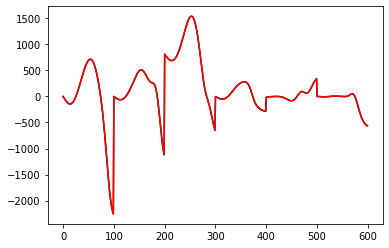

In [10]:
### VERIFICATION ###

# Plot tau_meas and tau_est

tau_est = np.matmul(W, phi_standard)

plt.plot(tau_meas, "k")
plt.plot(tau_est, "r")

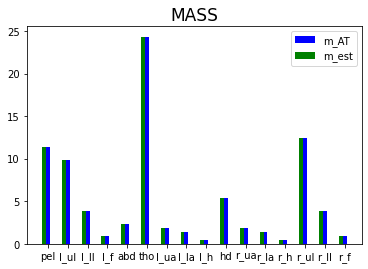

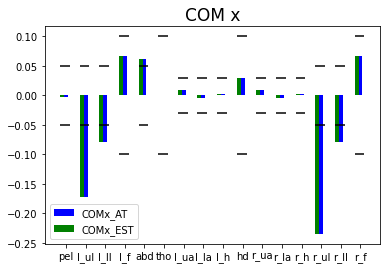

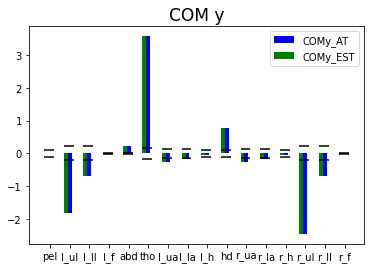

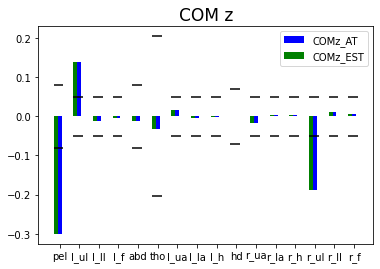

In [13]:
### COMPARATIVE BAR PLOT OF THE STANDARD PARAMETERS ###

names = [
    "pel",
    "l_ul",
    "l_ll",
    "l_f",
    "abd",
    "tho",
    "l_ua",
    "l_la",
    "l_h",
    "hd",
    "r_ua",
    "r_la",
    "r_h",
    "r_ul",
    "r_ll",
    "r_f",
]
phi_m_ref = []
phi_m_est = []

for ii in range(len(id_inertias)):
    phi_m_ref.append(phi_ref[10 * id_inertias[ii] + 9])
    phi_m_est.append(phi_standard[10 * id_inertias[ii] + 9])

m_AT = dict(zip(names, phi_m_ref))
m_est = dict(zip(names, phi_m_est))


X = np.arange(len(m_AT))
ax = plt.subplot(111)
ax.bar(X, m_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, m_est.values(), width=0.2, color="g", align="center")
ax.legend(("m_AT", "m_est"))
plt.xticks(X, m_AT.keys())
plt.title("MASS", fontsize=17)
plt.show()

phi_comx_ref = []
phi_comx_est = []

for ii in range(len(id_inertias)):
    phi_comx_ref.append(phi_ref[10 * id_inertias[ii] + 6])
    phi_comx_est.append(phi_standard[10 * id_inertias[ii] + 6])


comx_AT = dict(zip(names, phi_comx_ref))
comx_est = dict(zip(names, phi_comx_est))


X = np.arange(len(comx_AT))
ax = plt.subplot(111)
ax.bar(X, comx_AT.values(), width=0.2, color="b", align="center", label="COMx_AT")
ax.bar(
    X - 0.2, comx_est.values(), width=0.2, color="g", align="center", label="COMx_EST"
)
for ii in range(16):
    ax.hlines(COM_max[3 * ii], X[ii] - 0.3, X[ii] + 0.2, color="k")
    ax.hlines(COM_min[3 * ii], X[ii] - 0.3, X[ii] + 0.2, color="k")
ax.legend()
plt.xticks(X, comx_AT.keys())
plt.title("COM x", fontsize=17)
plt.show()

phi_comy_ref = []
phi_comy_est = []

for ii in range(len(id_inertias)):
    phi_comy_ref.append(phi_ref[10 * id_inertias[ii] + 7])
    phi_comy_est.append(phi_standard[10 * id_inertias[ii] + 7])

comy_AT = dict(zip(names, phi_comy_ref))
comy_est = dict(zip(names, phi_comy_est))

X = np.arange(len(comy_AT))
ax = plt.subplot(111)
ax.bar(X, comy_AT.values(), width=0.2, color="b", align="center", label="COMy_AT")
ax.bar(
    X - 0.2, comy_est.values(), width=0.2, color="g", align="center", label="COMy_EST"
)
for ii in range(16):
    ax.hlines(COM_max[3 * ii + 1], X[ii] - 0.3, X[ii] + 0.2, color="k")
    ax.hlines(COM_min[3 * ii + 1], X[ii] - 0.3, X[ii] + 0.2, color="k")
ax.legend()
plt.xticks(X, comy_AT.keys())
plt.title("COM y", fontsize=17)
plt.show()

phi_comz_ref = []
phi_comz_est = []

for ii in range(len(id_inertias)):
    phi_comz_ref.append(phi_ref[10 * id_inertias[ii] + 8])
    phi_comz_est.append(phi_standard[10 * id_inertias[ii] + 8])

comz_AT = dict(zip(names, phi_comz_ref))
comz_est = dict(zip(names, phi_comz_est))

X = np.arange(len(comz_AT))
ax = plt.subplot(111)
ax.bar(X, comz_AT.values(), width=0.2, color="b", align="center", label="COMz_AT")
ax.bar(
    X - 0.2, comz_est.values(), width=0.2, color="g", align="center", label="COMz_EST"
)
for ii in range(16):
    ax.hlines(COM_max[3 * ii + 2], X[ii] - 0.3, X[ii] + 0.2, color="k")
    ax.hlines(COM_min[3 * ii + 2], X[ii] - 0.3, X[ii] + 0.2, color="k")
ax.legend()
plt.xticks(X, comz_AT.keys())
plt.title("COM z", fontsize=17)
plt.show()

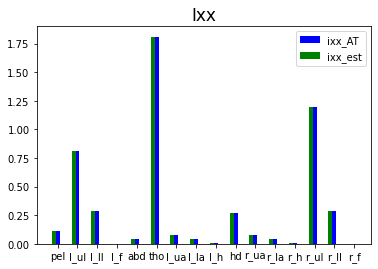

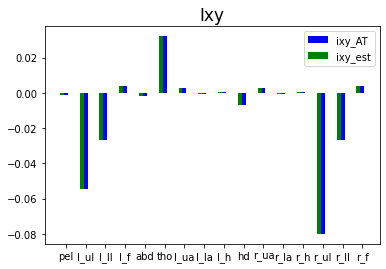

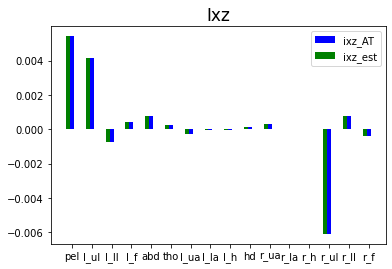

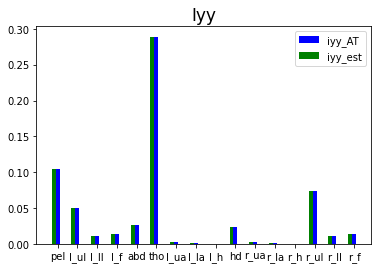

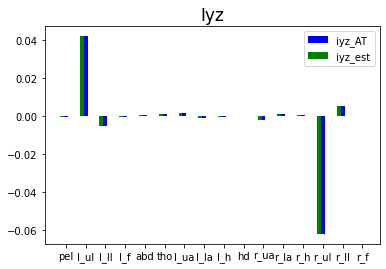

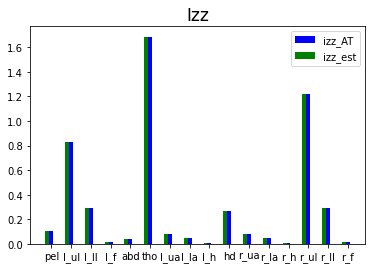

In [15]:
names = [
    "pel",
    "l_ul",
    "l_ll",
    "l_f",
    "abd",
    "tho",
    "l_ua",
    "l_la",
    "l_h",
    "hd",
    "r_ua",
    "r_la",
    "r_h",
    "r_ul",
    "r_ll",
    "r_f",
]

phi_ixx_ref = []
phi_ixx_est = []

for ii in range(len(id_inertias)):
    phi_ixx_ref.append(phi_ref[10 * id_inertias[ii]])
    phi_ixx_est.append(phi_standard[10 * id_inertias[ii]])

ixx_AT = dict(zip(names, phi_ixx_ref))
ixx_est = dict(zip(names, phi_ixx_est))

X = np.arange(len(ixx_AT))
ax = plt.subplot(111)
ax.bar(X, ixx_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, ixx_est.values(), width=0.2, color="g", align="center")
ax.legend(("ixx_AT", "ixx_est"))
plt.xticks(X, ixx_AT.keys())
plt.title("Ixx", fontsize=17)
plt.show()

phi_ixy_ref = []
phi_ixy_est = []

for ii in range(len(id_inertias)):
    phi_ixy_ref.append(phi_ref[10 * id_inertias[ii] + 1])
    phi_ixy_est.append(phi_standard[10 * id_inertias[ii] + 1])

ixy_AT = dict(zip(names, phi_ixy_ref))
ixy_est = dict(zip(names, phi_ixy_est))

X = np.arange(len(ixy_AT))
ax = plt.subplot(111)
ax.bar(X, ixy_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, ixy_est.values(), width=0.2, color="g", align="center")
ax.legend(("ixy_AT", "ixy_est"))
plt.xticks(X, ixy_AT.keys())
plt.title("Ixy", fontsize=17)
plt.show()

phi_ixz_ref = []
phi_ixz_est = []

for ii in range(len(id_inertias)):
    phi_ixz_ref.append(phi_ref[10 * id_inertias[ii] + 2])
    phi_ixz_est.append(phi_standard[10 * id_inertias[ii] + 2])

ixz_AT = dict(zip(names, phi_ixz_ref))
ixz_est = dict(zip(names, phi_ixz_est))

X = np.arange(len(ixz_AT))
ax = plt.subplot(111)
ax.bar(X, ixz_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, ixz_est.values(), width=0.2, color="g", align="center")
ax.legend(("ixz_AT", "ixz_est"))
plt.xticks(X, ixz_AT.keys())
plt.title("Ixz", fontsize=17)
plt.show()

phi_iyy_ref = []
phi_iyy_est = []

for ii in range(len(id_inertias)):
    phi_iyy_ref.append(phi_ref[10 * id_inertias[ii] + 3])
    phi_iyy_est.append(phi_standard[10 * id_inertias[ii] + 3])

iyy_AT = dict(zip(names, phi_iyy_ref))
iyy_est = dict(zip(names, phi_iyy_est))

X = np.arange(len(iyy_AT))
ax = plt.subplot(111)
ax.bar(X, iyy_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, iyy_est.values(), width=0.2, color="g", align="center")
ax.legend(("iyy_AT", "iyy_est"))
plt.xticks(X, iyy_AT.keys())
plt.title("Iyy", fontsize=17)
plt.show()

phi_iyz_ref = []
phi_iyz_est = []

for ii in range(len(id_inertias)):
    phi_iyz_ref.append(phi_ref[10 * id_inertias[ii] + 4])
    phi_iyz_est.append(phi_standard[10 * id_inertias[ii] + 4])

iyz_AT = dict(zip(names, phi_iyz_ref))
iyz_est = dict(zip(names, phi_iyz_est))

X = np.arange(len(iyz_AT))
ax = plt.subplot(111)
ax.bar(X, iyz_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, iyz_est.values(), width=0.2, color="g", align="center")
ax.legend(("iyz_AT", "iyz_est"))
plt.xticks(X, iyz_AT.keys())
plt.title("Iyz", fontsize=17)
plt.show()

phi_izz_ref = []
phi_izz_est = []

for ii in range(len(id_inertias)):
    phi_izz_ref.append(phi_ref[10 * id_inertias[ii] + 5])
    phi_izz_est.append(phi_standard[10 * id_inertias[ii] + 5])

izz_AT = dict(zip(names, phi_izz_ref))
izz_est = dict(zip(names, phi_izz_est))

X = np.arange(len(izz_AT))
ax = plt.subplot(111)
ax.bar(X, izz_AT.values(), width=0.2, color="b", align="center")
ax.bar(X - 0.2, izz_est.values(), width=0.2, color="g", align="center")
ax.legend(("izz_AT", "izz_est"))
plt.xticks(X, izz_AT.keys())
plt.title("Izz", fontsize=17)
plt.show()